 # The Role of the Third Sector in Public Health Service Provision

### 1.1 Lets load some dependancies

In [42]:
import os
import pandas as pd
from helper_functions import hide_toggle
from general_analysis_functions import (load_suppliers,
                                        load_payments,
                                        scoring_figures,
                                        summarize_payments,
                                        plot_match_distribution,
                                        summarize_payments,
                                        plot_macro_overview,
                                        analyze_registers,
                                        calc_total_files,
                                        make_table_one,
                                        check_payments)
from charity_analysis_functions import (tabulate_charities,
                                        icnpo_groupings,
                                        load_ccname,
                                        load_ccfin,
                                        load_ccclass,
                                        load_icpno,
                                        build_charity_df,
                                        make_gdf,
                                        make_ccg_to_gdf,
                                        plot_choropleths,
                                        plot_heatmap,
                                        charity_age,
                                        class_groupings,
                                        make_temporal_df,
                                        plot_temporal
                                       )
import geopandas as gpd
%load_ext autoreload
%autoreload 2
hide_toggle()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.2 Set paths

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), '../..', 'data'))
cc_path = os.path.join(data_path, 'data_cc')
ch_path = os.path.join(data_path, 'data_ch')
nhsdigital_path = os.path.join(data_path, 'data_nhsdigital')
master_path = os.path.join(data_path, 'data_masteringest')
merge_path = os.path.join(data_path, 'data_merge')
recon_path = os.path.join(data_path, 'data_reconciled')
norm_path = os.path.join(data_path, 'data_support', 'norm_dict.tsv')
support_path = os.path.join(data_path, 'data_support')
shape_path = os.path.join(data_path, 'data_shapefiles')
figure_path = os.path.abspath(os.path.join(
                              os.path.join(os.getcwd(),
                                           '../..', 'papers', 'figures')))
table_path = os.path.abspath(os.path.join(
                             os.path.join(os.getcwd(),
                                          '../..', 'papers', 'tables')))
hide_toggle()

### 1.2 Load key datasets

In [3]:
sup_df = load_suppliers(os.path.join(recon_path, 'recon_verified.tsv'))
ccg_pay_df = load_payments(os.path.join(merge_path, 'ccg_merged_with_recon.tsv'))
trust_pay_df = load_payments(os.path.join(merge_path, 'trust_merged_with_recon.tsv'))
cc_name = load_ccname(cc_path, norm_path)
icnpo_df, icnpo_lookup = load_icpno(support_path)
cc_fin = load_ccfin(cc_path)
cc_class = load_ccclass(cc_path)
hide_toggle()

In [4]:
def build_top_charity_df(pay_df, Year):
    cc_count = pay_df.groupby(['verif_match'])['verif_match'].\
        count().reset_index(name="count")
    cc_val = pay_df.groupby(['verif_match'])['amount'].sum().reset_index()
    cc_merge = pd.merge(cc_val, cc_count, how='left', on='verif_match')
    cc_merge = pd.merge(cc_merge, cc_name, how='left',
                        left_on='verif_match',
                        right_on='norm_name')
    cc_merge['Registration Number'] = pd.to_numeric(cc_merge['regno'],
                                      errors='coerce')
    cc_merge = cc_merge[cc_merge['Registration Number'].notnull()]
    cc_merge['Registration Number'] = cc_merge['Registration Number'].astype(int)
    cc_merge['amount'] = cc_merge['amount'].astype(int)
    cc_merge['Value of Payments (%)'] = (cc_merge['amount']/cc_merge['amount'].sum())*100
    cc_merge['Number of Payments (%)'] = (cc_merge['count']/cc_merge['count'].sum())*100
    cc_merge = cc_merge.rename({'name': 'Charity Name'}, axis=1)
    cc_merge = cc_merge.rename({'regdate': 'Registration Date'}, axis=1)
    cc_merge = cc_merge[['Charity Name' ,'Number of Payments (%)',
                         'Value of Payments (%)','Registration Number',
                         'Registration Date']]
    cc_merge['Charity Name'] = cc_merge['Charity Name'].str.strip()
    cc_merge = cc_merge[cc_merge['Charity Name'].notnull()]
    cc_merge = cc_merge[~cc_merge['Charity Name'].str.contains('NHS FOUNDATION', na=False)]
    cc_merge = cc_merge[~cc_merge['Charity Name'].str.contains('FOUNDATION TRUST', na=False)]
    cc_merge = cc_merge[~cc_merge['Charity Name'].str.contains('HOSPITAL TRUST', na=False)]
    cc_merge = cc_merge[~cc_merge['Charity Name'].str.contains('NHS TRUST', na=False)]
    cc_merge = cc_merge[~cc_merge['Charity Name'].str.contains('NHS TRUST', na=False)]
    cc_merge = cc_merge.sort_values('Value of Payments (%)', ascending=False)[0:10]
    cc_merge = cc_merge.reset_index()
    cc_merge['Rank'] = cc_merge.index+1
    cc_merge= cc_merge.drop('index', 1)
    cc_merge = cc_merge.set_index('Charity Name')
    cc_merge['Year'] = Year
    return cc_merge
        
def build_top_charity_suppliers(pay_df, d_path, filename):    
    list_of_dfs = []

    cc_pay_df = pay_df[pay_df['match_type'].str.contains('Charity')]
    list_of_dfs.append(build_top_charity_df(cc_pay_df, 'All Years'))
    for year in range(2013,2020):
        temp_df = cc_pay_df[cc_pay_df['date'].astype(str).str.contains(str(year))]

        ret_df = build_top_charity_df(temp_df, str(year))
        list_of_dfs.append(ret_df)
    pd.concat(list_of_dfs).to_csv(os.path.join(data_path, 'data_dashboard', filename))
    
build_top_charity_suppliers(ccg_pay_df, data_path, 'ccg_top10_charities.csv')
build_top_charity_suppliers(trust_pay_df, data_path, 'trust_top10_charities.csv')

In [5]:
def build_top_org_df(pay_df, cc_pay_df, Year, trust_list, varname):
    cc_count = cc_pay_df.groupby(['dept'])['dept'].\
        count().reset_index(name="Charity Count")
    total_count = pay_df.groupby(['dept'])['dept'].\
        count().reset_index(name="total_count")
    cc_val = cc_pay_df.groupby(['dept'])['amount'].sum().reset_index(name='Charity Value (£)')
    total_val = pay_df.groupby(['dept'])['amount'].sum().reset_index(name='total_amount')
    cc_merge = pd.merge(cc_val, cc_count, how='left', on='dept')
    cc_merge = pd.merge(cc_merge, total_count, how='left', on='dept')
    cc_merge = pd.merge(cc_merge, total_val, how='left', on='dept')
    cc_merge['Count to VCS (%)'] = (cc_merge['Charity Count']/cc_merge['total_count'])*100
    cc_merge['Value to VCS (%)'] = (cc_merge['Charity Value (£)']/cc_merge['total_amount'])*100
    cc_merge = cc_merge[cc_merge['total_count']>100]
    cc_merge = cc_merge.sort_values('Value to VCS (%)', ascending=False)[0:10]
    cc_merge = cc_merge.reset_index()
    cc_merge['Rank'] = cc_merge.index+1
    cc_merge = cc_merge.rename({'dept': 'NHS Abrev'}, axis=1)
    cc_merge = cc_merge.set_index('NHS Abrev')
    cc_merge['Year'] = Year
    cc_merge = cc_merge.drop('index', 1)
    cc_merge = cc_merge.drop('total_count', 1)
    cc_merge = cc_merge.drop('total_amount', 1)
    cc_merge.index.names = ['NHS Abrev']
    cc_merge = pd.merge(cc_merge, trust_list, how='left', left_index=True, right_on='abrev')
    cc_merge = cc_merge.rename({'abrev': 'NHS Abrev'}, axis=1)
    cc_merge['NHS Abrev'] = cc_merge['NHS Abrev'].str.replace('_CCG', '')
    cc_merge['NHS Abrev'] = cc_merge['NHS Abrev'].str.replace('_', ' ')
    cc_merge = cc_merge.set_index('NHS Abrev')
    cc_merge = cc_merge.rename({varname[0]: varname[1]}, axis=1)
    return cc_merge
    
def build_top_org_procurers(pay_df, d_path, filename, orgtype):
    trust_list = pd.read_excel(os.path.join(d_path, 'data_support', orgtype+'_list.xls'))
    if orgtype=='trust':
        varnames = ['trust name', 'NHS Trust']
    elif orgtype=='ccg':
        varnames = ['ccg19nm', 'NHS CCG']
    trust_list = trust_list[[varnames[0], 'abrev']]
#    cc_merge = pd.merge(cc_merge, trust_list, how='left', left_index=True, right_on='abrev')
    cc_pay_df = pay_df[pay_df['match_type'].str.contains('Charity')]
    cc_pay_df = cc_pay_df[~cc_pay_df['verif_match'].str.contains('NHS FOUNDATION', na=False)]
    cc_pay_df = cc_pay_df[~cc_pay_df['verif_match'].str.contains('FOUNDATION TRUST', na=False)]
    cc_pay_df = cc_pay_df[~cc_pay_df['verif_match'].str.contains('HOSPITAL TRUST', na=False)]
    cc_pay_df = cc_pay_df[~cc_pay_df['verif_match'].str.contains('NHS TRUST', na=False)]
    cc_pay_df = cc_pay_df[~cc_pay_df['verif_match'].str.contains('NHS TRUST', na=False)]
    list_of_dfs = []
    list_of_dfs.append(build_top_org_df(pay_df, cc_pay_df, 'All Years', trust_list, varnames))
    for year in range(2013,2020):
        temp_df = pay_df[pay_df['date'].astype(str).str.contains(str(year))]
        temp_cc_df = cc_pay_df[cc_pay_df['date'].astype(str).str.contains(str(year))]
        ret_df = build_top_org_df(temp_df, temp_cc_df, str(year), trust_list, varnames)
        list_of_dfs.append(ret_df)
    pd.concat(list_of_dfs).to_csv(os.path.join(data_path, 'data_dashboard', filename))

build_top_org_procurers(ccg_pay_df, data_path, 'ccg_top10_orgs.csv', 'ccg')
build_top_org_procurers(trust_pay_df, data_path, 'trust_top10_orgs.csv', 'trust')

In [56]:
def build_tables(pay_df, d_path, filename, orgtype):
    trust_list = pd.read_excel(os.path.join(d_path, 'data_support',
                                            orgtype+'_list.xls'))
    if orgtype=='trust':
        varnames = ['trust name', 'NHS Trust', 'Latitude', 'Longitude']
        trust_list = trust_list[[varnames[0], 'abrev','Latitude', 'Longitude']]
    elif orgtype=='ccg':
        varnames = ['ccg19nm', 'NHS CCG']
        trust_list = trust_list[[varnames[0], 'abrev']]
    columns = ['Number of Payments', 'Value of Payments (m)',
               'Number of Datasets',
               'Value to VCS (%)',
               'Count to VCS (%)',
               'Highest Value Charity Recipient']
    df = trust_list.reindex(trust_list.columns.tolist() + columns, axis=1)
    df = df[df['abrev'].notnull()]
    df = df.set_index('abrev')
    df['Highest Value Charity Recipient'] = df['Highest Value Charity Recipient'].astype(str)
    for index in df.index:
        temp_df = pay_df[pay_df['dept']==index]
        if len(temp_df)>0:
            temp_cc = temp_df[pay_df['match_type'].str.contains('Charity')]
            df.at[index, 'Number of Payments'] = len(temp_df)
            df.at[index, 'Value of Payments (m)'] = int(temp_df['amount'].sum()/1000000)
            df.at[index, 'Number of Datasets'] = len(temp_df['file'].unique())
            temp_cc = temp_df[temp_df['match_type'].str.contains('Charity')]
            temp_cc = temp_cc[~temp_cc['verif_match'].str.contains('NHS FOUNDATION', na=False)]
            temp_cc = temp_cc[~temp_cc['verif_match'].str.contains('FOUNDATION TRUST', na=False)]
            temp_cc = temp_cc[~temp_cc['verif_match'].str.contains('HOSPITAL TRUST', na=False)]
            temp_cc = temp_cc[~temp_cc['verif_match'].str.contains('NHS TRUST', na=False)]
            temp_cc = temp_cc[~temp_cc['verif_match'].str.contains('NHS TRUST', na=False)]
            df.at[index, 'Number Payments to VCS'] = len(temp_cc)
            df.at[index, 'Value to VCS (%)'] = (temp_cc['amount'].sum()/
                                                temp_df['amount'].sum())*100
            df.at[index, 'Count to VCS (%)'] = (len(temp_cc)/len(temp_df))*100 
            df.at[index, 'Number of Charity Suppliers'] = len(temp_cc['verif_match'].unique())
            cc_val = temp_cc.groupby(['verif_match'])['amount'].sum().reset_index()
            try:
                most_cc = cc_val.sort_values(by='amount',
                                             ascending=False).reset_index()['verif_match'][0]
                df.at[index, 'Highest Value Charity Recipient'] = most_cc
            except (KeyError, IndexError):
                df.at[index, 'Highest Value Charity Recipient'] = 0
#            df = df.rename({varnames[0]: varnames[1]}, axis=1)
    df = df[df['Highest Value Charity Recipient'].notnull()]
    df = df[df['Number of Payments'].notnull()]
    df.index = df.index.rename('NHS Abrev')
    df.to_csv(os.path.join(data_path, 'data_dashboard', filename))
#build_tables(ccg_pay_df, data_path, 'ccg_table.csv', 'ccg')
build_tables(trust_pay_df, data_path, 'trust_table.csv', 'trust')

### 1.3 Load raw payments dataset

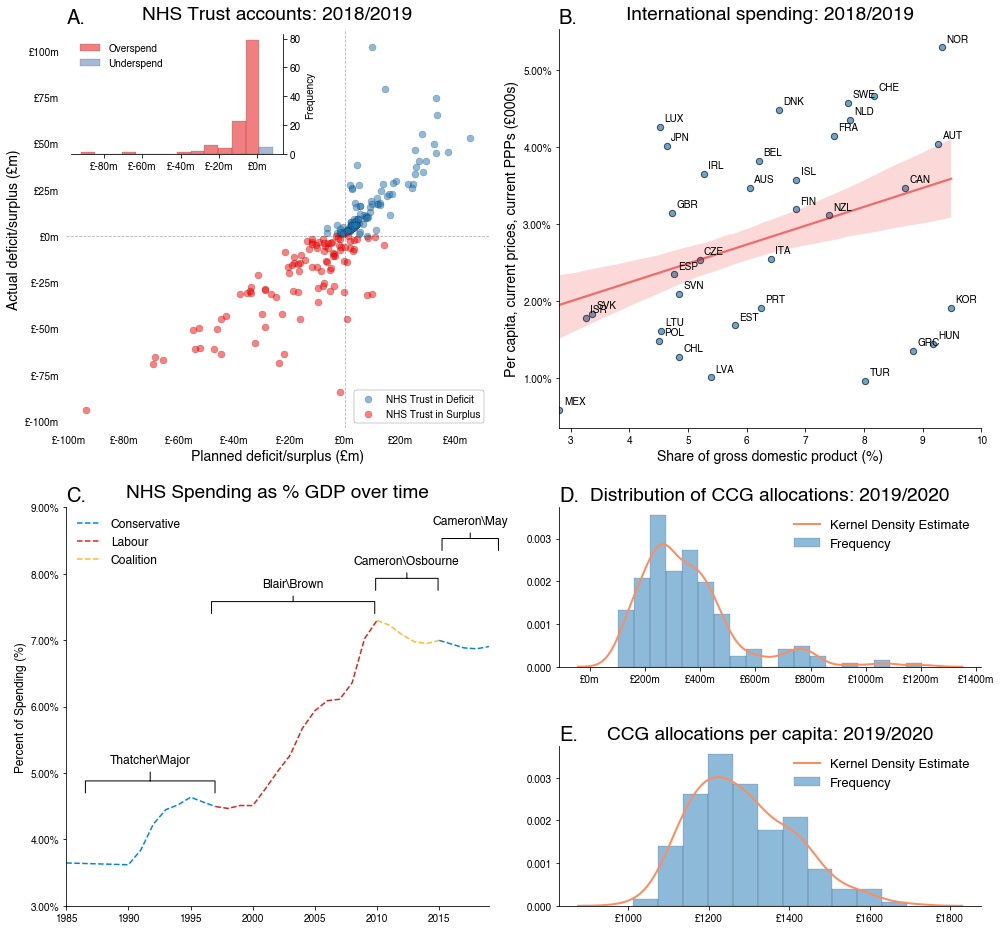

In [8]:
plot_macro_overview(data_path, figure_path)

## 2 Check and summarize the raw payments dataset

### how many institutions were there at the time of the last scrape?

In [9]:
print('There are 221 Trusts in our meta list.')
print('There are 191 Trusts in our meta list.')

There are 221 Trusts in our meta list.
There are 191 Trusts in our meta list.


### how many files did we get?

In [10]:
ccg_rawpath = os.path.join(data_path, 'data_nhsccgs', 'raw')
trust_rawpath = os.path.join(data_path, 'data_nhstrusts', 'raw')
ccg_files = calc_total_files(ccg_rawpath)[0]
ccg_folders = calc_total_files(ccg_rawpath)[1]
print('CCG folders: ' +  str(ccg_folders))
print('CCG files: ' +  str(ccg_files))

trust_files = calc_total_files(trust_rawpath)[0]
trust_folders = calc_total_files(trust_rawpath)[1]
print('Trust folders: ' +  str(trust_folders))
print('Trust files: ' +  str(trust_files))

CCG folders: 192
CCG files: 12709
Trust folders: 216
Trust files: 12518


### write a module to check the raw payments here

In [11]:
check_payments(ccg_pay_df,
               os.path.join(data_path,'data_support',
                            'filechecker_ccg.csv'), data_path, 'ccg', 50)
check_payments(trust_pay_df,
               os.path.join(data_path,'data_support',
                            'filechecker_trust.csv'), data_path, 'trust', 50)

Cool! No more ccg payments to check by order...
Cool! No more ccg payments to check by groupby...
Cool! No more trust payments to check by order...
Cool! No more trust payments to check by groupby...


### Analyze institutional registers

In [12]:
#emphasize this point re: uniqueness in article and check that this is what code is doing
analyze_registers(ch_path, cc_path, nhsdigital_path, master_path)

Number unique raw CH entries: 4490685
Number non-duplicated normalized CH entries: 4489992
Number unique raw CC entries: 469691
Number non-duplicated normalized CC entries: 463733
Number unique raw NHS Digital entries: 45739
Number non-duplicated normalized NHS Digital entries: 45560
Number unique raw combined entries: 4851121
Number non-duplicated normalized combined entries: 4873882
There are 51575 normalised unique names on both CH and CC
There are 1408 normalised unique names on both CH and NHS
There are 1280 normalised unique names on both CC and NHS
There are 371 normalised unique names on all 3


### Summarize stuff


In [13]:
ccg_pay_df = ccg_pay_df[(ccg_pay_df['date'] > '2010-01-01') & (ccg_pay_df['date'] < '2020-04-01')]
summarize_payments(ccg_pay_df, 'CCG')

Describing cleaned CCG payments dataset!
Length of dataset: 589784
Total unique raw suppliers: 15698
Total unique verified suppliers: 7833
Total value (£) of dataset: 212036076347
Smallest value payment: 25000
Biggest value payment: 58249359
Average value payment: 359514
Earliest payment was: 2010-12-24 00:00:00
Latest payment was: 2020-02-29 00:00:00
Most payments is:  NHS_LEE_CCG (18197)
Highest value payments is: NHS_LEE_CCG (£6338077468)
Most payments: HMRC (6579)
Highest value of payments is: SHEFFIELD TEACHING HOSPITALS NHS FOUNDATION TRUST (3370046467.0)
Number of organisations in clean dataset is: 173
Number of files in clean dataset is: 7742


In [14]:
summarize_payments(trust_pay_df, 'Trust')

Describing cleaned Trust payments dataset!
Length of dataset: 640930
Total unique raw suppliers: 24366
Total unique verified suppliers: 11270
Total value (£) of dataset: 88990234745
Smallest value payment: 25000
Biggest value payment: 139956473
Average value payment: 138845
Earliest payment was: 2010-01-04 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_GUY_Trust (26139)
Highest value payments is: NHS_IMP_Trust (£3979230540)
Most payments: NHS SUPPLY CHAIN (27391)
Highest value of payments is: HMRC GOVERNMENT EMPLOYERS ACCOUNT (3546148365.0)
Number of organisations in clean dataset is: 189
Number of files in clean dataset is: 8471


In [15]:
summarize_payments(pd.concat([trust_pay_df, ccg_pay_df],
                             ignore_index=True), 'Combined')

Describing cleaned Combined payments dataset!
Length of dataset: 1230714
Total unique raw suppliers: 38053
Total unique verified suppliers: 17372
Total value (£) of dataset: 301026311092
Smallest value payment: 25000
Biggest value payment: 139956473
Average value payment: 244594
Earliest payment was: 2010-01-04 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_GUY_Trust (26139)
Highest value payments is: NHS_LEE_CCG (£6338077468)
Most payments: NHS SUPPLY CHAIN (28069)
Highest value of payments is: HMRC GOVERNMENT EMPLOYERS ACCOUNT (3546148365.0)
Number of organisations in clean dataset is: 362
Number of files in clean dataset is: 16122


In [16]:
make_table_one(ccg_pay_df, trust_pay_df, table_path)

## 3 Visualise the approximate matches

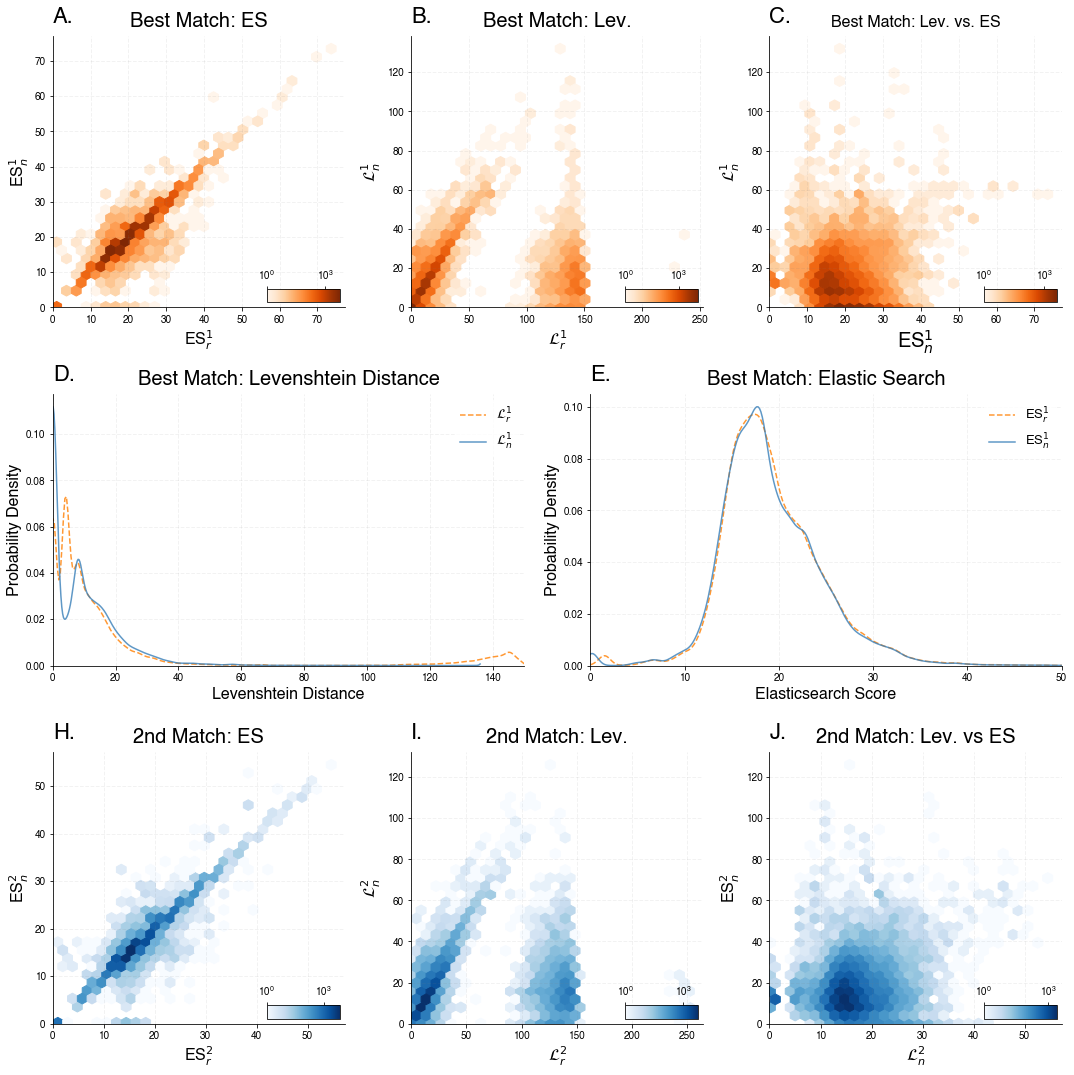

In [17]:
scoring_figures(sup_df, figure_path, (15, 15))

## 4 Visualise the institutional distribution

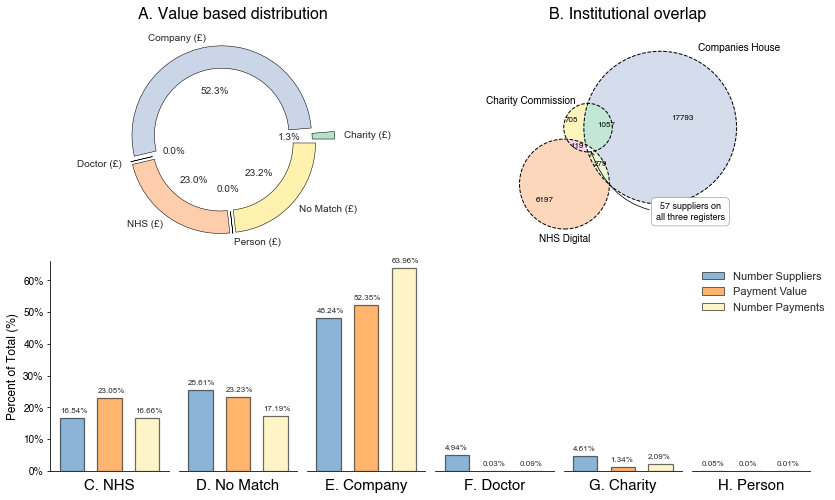

In [18]:
plot_match_distribution(sup_df, trust_pay_df, figure_path, (12, 7))

## 5. Summarsize charitable payments and suppliers

### 5.1 Build charity dataframe

In [19]:
pay_df_cc, cc_sup = build_charity_df(pd.concat([trust_pay_df, ccg_pay_df],
                                               ignore_index=True),
                                     cc_name, icnpo_df, cc_fin, data_path)

We are missing 77 registration numbers
Can't do anything about that...
This seems to be where two charities have the same normalised name, and neither has been  removed from the register
This leaves us with 1444 charities with regnos.
We are missing 227 incomes
Can't do anything about that...
We are missing 56 ICNPO numbers which have charity numbers
The unmapped charities are in data\support\unmapped_icnpo.csv


### 5.1 Charity summary

In [20]:
summarize_payments(pay_df_cc, 'charitable')

Describing cleaned charitable payments dataset!
Length of dataset: 41642
Total unique raw suppliers: 1824
Total unique verified suppliers: 1519
Total value (£) of dataset: 9240525617
Smallest value payment: 25000
Biggest value payment: 15403136
Average value payment: 221903
Earliest payment was: 2010-01-29 00:00:00
Latest payment was: 2020-03-31 00:00:00
Most payments is:  NHS_DORS_CCG (1362)
Highest value payments is: NHS_DORS_CCG (£1261409267)
Most payments: NUFFIELD HEALTH (2195)
Highest value of payments is: ROYAL BOURNEMOUTH AND CHRISTCHURCH HOSPITALS NHS FOUNDATION TRUST (1216566653.0)
Number of organisations in clean dataset is: 350
Number of files in clean dataset is: 10496


### 5.2 Tabulate the charities (groupby)

In [21]:
tabulate_charities(pay_df_cc, cc_name, icnpo_df, cc_fin)

                verif_match     amount  count    regno     regdate  ICNPO        income  CC Rank
            NUFFIELD HEALTH  278246286   2250   205533  1962-09-22   3100  4.835600e+09        6
 MARIE STOPES INTERNATIONAL   43530169   1112   265543  1973-05-09   3400  1.603164e+09       58
                       BPAS   39187583    782   289145  1984-04-25   3400  2.078000e+08     1366
                      PULSE  122031366    756  1098510  2003-07-11   3100  4.890700e+04   162243
          ST JOHN AMBULANCE   33859608    729  1077265  1999-09-02   3400  6.001000e+08      456
                MARIE CURIE   56955581    560   207994  1962-09-22   3400  1.091030e+09      243
         ALZHEIMERS SOCIETY   27012536    542   296645  1987-04-23   3400  6.660080e+08      423
        ST BARNABAS HOSPICE   48643690    469  1053814  1996-03-15   3200  7.631532e+07     4444
              ANTHONY NOLAN   16712447    458   803716  1990-07-12   3400  2.935340e+08     1047
            METHODIST HOMES   

### 5.3 ICNPO and Class Distributions

In [22]:
icnpo_groupings(pay_df_cc, cc_name, icnpo_df, icnpo_lookup)

    icnpo                        icnpo_group   count  amount
0    1100                  Culture and sport   2.099   2.876
1    1200                  Culture and sport   1.050   0.106
2    1300                  Culture and sport   0.070   0.001
3    2100                          Education   0.910   0.264
4    2110                          Education   0.210   0.013
5    2120                          Education   0.280   0.042
6    2130                          Education   0.280   0.161
7    2200                          Education   0.490   0.158
8    2210                          Education   0.000   0.000
9    2300                          Education   1.330   0.223
10   2400                          Education   1.050   0.185
11   2410                          Education   1.330   0.994
12   3100                             Health   7.838  29.628
13   3200                             Health   9.587  16.471
14   3210                             Health   0.140   0.131
15   3300               

In [23]:
class_groupings(pay_df_cc, cc_name, cc_class)

                                            classtext  amount_pc  count_pc
0                               Accommodation/housing      0.595     2.053
1                Acts As An Umbrella Or Resource Body      4.338     2.213
2                                       Amateur Sport      0.095     0.823
3                                             Animals      0.004     0.032
4           Armed Forces/emergency Service Efficiency      0.012     0.056
5                       Arts/culture/heritage/science      0.271     1.087
6                               Children/young People      8.188     5.729
7                                          Disability      3.290     4.666
8           Economic/community Development/employment      0.516     2.629
9                                  Education/training      5.553     6.440
10                                 Elderly/old People      8.251     5.433
11                  Environment/conservation/heritage      0.243     0.607
12                       

In [24]:
pay_df_cc = pay_df_cc.sort_values(ascending=False, by='amount')
for column in ['verif_match', 'supplier']:
    pay_df_cc = pay_df_cc[~pay_df_cc[column].str.contains('NHS FOUNDATION')]
    pay_df_cc = pay_df_cc[~pay_df_cc[column].str.contains('FOUNDATION TRUST')]
    pay_df_cc = pay_df_cc[~pay_df_cc[column].str.contains('HOSPITAL TRUST')]
    pay_df_cc = pay_df_cc[~pay_df_cc[column].str.contains('NHS TRUST')]
    pay_df_cc = pay_df_cc[~pay_df_cc[column].str.contains('NHS TRUST')]
    pay_df_cc = pay_df_cc[pay_df_cc['date'] > '2010-01-01']
    

### 5.4 Geospatial Distribution

                                     ccg19nm           abrev
0    NHS Airedale, Wharfedale And Craven CCG     NHS_AWC_CCG
1                            NHS Ashford CCG     NHS_ASH_CCG
2               NHS Barking And Dagenham CCG    NHS_BARK_CCG
3                             NHS Barnet CCG  NHS_BARNET_CCG
4                           NHS Barnsley CCG   NHS_BARNS_CCG
..                                       ...             ...
186                    NHS Wigan Borough CCG     NHS_WAB_CCG
187                        NHS Wiltshire CCG    NHS_WILT_CCG
188                           NHS Wirral CCG    NHS_WIRR_CCG
189                    NHS Wolverhampton CCG    NHS_WOLV_CCG
190                      NHS Wyre Forest CCG    NHS_WYRE_CCG

[191 rows x 2 columns]


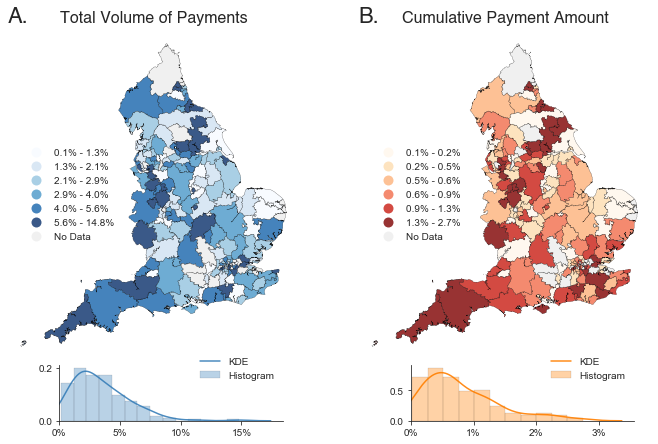

In [40]:
ccg_merged = make_ccg_to_gdf(ccg_pay_df, pay_df_cc,
                             support_path)
gdf=make_gdf(ccg_merged, shape_path, support_path)
plot_choropleths(gdf, figure_path)

### 5.5 Charity Age Distribution

In [ ]:
charity_age(pd.concat([trust_pay_df, ccg_pay_df],
                                               ignore_index=True), cc_sup, cc_name, cc_class, figure_path)

### 5.6 Charity Income Distribution

In [ ]:
ts_plot, ts_icnpo_plot = make_temporal_df(pd.concat([trust_pay_df, ccg_pay_df],
                                          ignore_index=True), pay_df_cc, icnpo_df, cc_name)
plot_temporal(ts_plot)

In [ ]:
plot_heatmap(ts_icnpo_plot[36:], figure_path)

### 5.7 Over TIme